# The solution to the [task](https://www.kaggle.com/datasets/andrewmvd/face-mask-detection/data)

In [ ]:
!pip install kaggle

In [ ]:
!mv ./kaggle.json ~/.kaggle/
!kaggle datasets download andrewmvd/face-mask-detection
!unzip -q face-mask-detection.zip -d /content/dataset/

100% 398M/398M [00:02<00:00, 180MB/s]
100% 398M/398M [00:02<00:00, 144MB/s]


In [ ]:
import numpy as np
import torch
import torchvision.transforms as T

import os
import shutil
import xml.etree.ElementTree as ET
from glob import glob
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

In [ ]:
DATASET_DIR = '/content/dataset'
IMAGE_DIR = '/content/dataset/images'
ANNOTATIONS_DIR = '/content/dataset/annotations'

In [ ]:
def voc_to_yolo(bndbox, w, h):
  # bndbox: [xmin, ymin, xmax, ymax]
  x_center = (bndbox[0] + bndbox[2]) / 2 / w
  y_center = (bndbox[1] + bndbox[3]) / 2 / h
  w_absolute = (bndbox[2] - bndbox[0]) / w
  h_absolute = (bndbox[3] - bndbox[1]) / h

  return [x_center, y_center, w_absolute, h_absolute]


def preprocess(labels_dir):
  if not os.path.isdir(labels_dir):
    print(f'The directory {labels_dir} does not exist! Creating the directory...')
    os.mkdir(labels_dir)
  elif len(os.listdir(labels_dir)) > 0:
    print(f'The directory {labels_dir} is not empty! Stopping the preprocessing...')
    return

  print('Directory {dir} contains of:\n\t{num_xml_files} .xml files\n\t{num_files} files'.format(
      dir=ANNOTATIONS_DIR,
      num_files=len(os.listdir(ANNOTATIONS_DIR)),
      num_xml_files=len(glob(ANNOTATIONS_DIR + '/*.xml'))
  ))

  classes = []
  for filename in tqdm(glob(f'{ANNOTATIONS_DIR}/*.xml')):
    root = ET.parse(filename).getroot()
    label_path = os.path.join(labels_dir, os.path.splitext(root.find('filename').text)[0] + '.txt')
    w = int(root.find('size').find('width').text)
    h = int(root.find('size').find('height').text)
    result = []
    for obj in root.findall('object'):
      class_name = obj.find('name').text
      if class_name not in classes:
        classes.append(class_name)

      label = classes.index(class_name)
      bbox = [int(item.text) for item in obj.find('bndbox')]
      yolo_bbox = voc_to_yolo(bbox, w, h)
      result.append('{label} {bbox}'.format(
          label=label,
          bbox=' '.join([str(item) for item in yolo_bbox])
      ))

    with open(label_path, 'w') as f:
      f.write('\n'.join(result))

  with open(f'{DATASET_DIR}/classes.txt', 'w') as f:
    f.write(str(classes))

  print(f'Removing the directory {ANNOTATIONS_DIR}...')
  shutil.rmtree(ANNOTATIONS_DIR)

def split_data(test_size=.2):
  images_dir = os.path.join(DATASET_DIR, 'images')
  labels_dir = os.path.join(DATASET_DIR, 'labels')
  assert os.path.isdir(images_dir), f'The directory {images_dir} does not exist!'
  assert os.path.isdir(labels_dir), f'The directory {labels_dir} does not exist!'
  assert len(os.listdir(images_dir)) == len(os.listdir(labels_dir)),\
  f'The number of files in {images_dir} and {labels_dir} are not the same!\
  \n\t{images_dir} contains of {len(os.listdir(images_dir))} files\
  \n\t{labels_dir} contains of {len(os.listdir(labels_dir))} files'

  train_dir = os.path.join(DATASET_DIR, 'train')
  test_dir = os.path.join(DATASET_DIR, 'test')
  for dir in [train_dir, test_dir]:
    if not os.path.isdir(dir):
      print(f'Creating the directory {dir}...')
      os.mkdir(dir)
    elif len(os.listdir(dir)) > 0:
      print(f'The directory {dir} is not empty! Stopping the procedure...')

    os.mkdir(os.path.join(dir, 'images'))
    os.mkdir(os.path.join(dir, 'labels'))


  image_paths = os.listdir(images_dir)
  train_image_paths, test_image_paths = train_test_split(image_paths, test_size=test_size)
  for filename in tqdm(train_image_paths, desc='Preprocessing train data'):
    basename = os.path.splitext(filename)[0]
    last_image_path = os.path.join(images_dir, filename)
    new_image_path = os.path.join(train_dir, 'images', filename)
    last_label_path = os.path.join(labels_dir, f'{basename}.txt')
    new_label_path = os.path.join(train_dir, 'labels', f'{basename}.txt')
    shutil.move(last_image_path, new_image_path)
    shutil.move(last_label_path, new_label_path)

  for filename in tqdm(test_image_paths, desc='Preprocessing test data'):
    basename = os.path.splitext(filename)[0]
    last_image_path = os.path.join(images_dir, filename)
    new_image_path = os.path.join(test_dir, 'images', filename)
    last_label_path = os.path.join(labels_dir, f'{basename}.txt')
    new_label_path = os.path.join(test_dir, 'labels', f'{basename}.txt')
    shutil.move(last_image_path, new_image_path)
    shutil.move(last_label_path, new_label_path)

  shutil.rmtree(os.path.join(DATASET_DIR, 'images'))
  shutil.rmtree(os.path.join(DATASET_DIR, 'labels'))

In [ ]:
preprocess('/content/dataset/labels')
split_data()

The directory /content/dataset/labels does not exist! Creating the directory...
Directory /content/dataset/annotations contains of:
	853 .xml files
	853 files


  0%|          | 0/853 [00:00<?, ?it/s]

Removing the directory /content/dataset/annotations...
Creating the directory /content/dataset/train...
Creating the directory /content/dataset/test...


Preprocessing train data:   0%|          | 0/682 [00:00<?, ?it/s]

Preprocessing test data:   0%|          | 0/171 [00:00<?, ?it/s]

In [ ]:
!pip install ultralytics

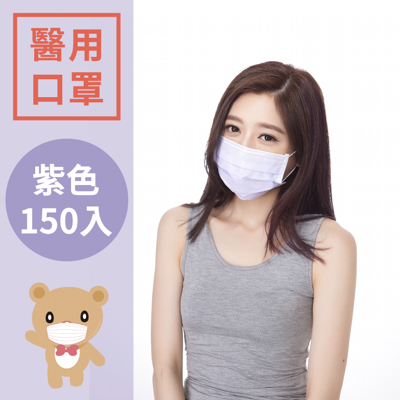

In [ ]:
Image.open(glob('dataset/train/images/*.png')[0])

In [ ]:
yaml_text = '''train: /content/dataset/train/images
val: /content/dataset/test/images

nc: 3
names: ["with_mask", "without_mask", "mask_weared_incorrect"]'''


with open('./dataset/data.yaml', 'w') as f:
  f.write(yaml_text)

In [ ]:
from ultralytics import YOLO

model = YOLO('yolov8n.pt')

model.train(data='./dataset/data.yaml', epochs=50, verbose=False)

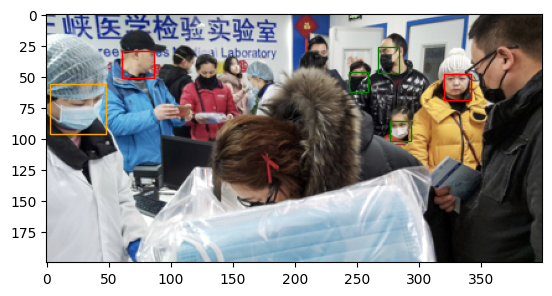

In [ ]:
def draw(filename, conf_threshold=.6):
  image = cv2.imread(filename, cv2.IMREAD_COLOR)#cv2.cvtColor(cv2.imread(filename, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
  colors = ['green', 'red', 'orange']
  fig, ax = plt.subplots()
  ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
  result = model(image)[0].boxes
  cls = result.cls.cpu()
  confs = result.conf.cpu()
  mask = confs > conf_threshold
  for cl, rect_ in zip(cls[mask].tolist(), result.xywh.cpu()[mask].tolist()):
    x, y, w, h = rect_
    x = x - w / 2
    y = y - h / 2
    rect = patches.Rectangle(
        (x, y), w, h, linewidth=1, fill=False, edgecolor=colors[int(cl)],
    )
    ax.add_patch(rect)

  plt.show()

#filename = np.random.choice(glob('./dataset/test/images/*.png'))
draw(filename)

In [ ]:

# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time

In [ ]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;

    var pendingResolve = null;
    var shutdown = false;

    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }

    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }

    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);

      const modelOut = document.createElement('div');
      modelOut.innerHTML = "Status:";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);

      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);

      const instruction = document.createElement('div');
      instruction.innerHTML =
          '' +
          'When finished, click here or on the video to stop this demo';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };

      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);

      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();

      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }

      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }

      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;

      return {'create': preShow - preCreate,
              'show': preCapture - preShow,
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)

def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [ ]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0
colors = [(0, 255, 0), (255, 0, 0), (0, 0, 255)]
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    img = js_to_image(js_reply["img"])
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #img = T.ToPILImage()(T.ToTensor()(img))
    # create transparent overlay for bounding box
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)

    # grayscale image for face detection
    with torch.no_grad():
      result = model(img)[0].boxes

    cls = result.cls.cpu()
    if len(cls) == 0: continue
    confs = result.conf.cpu()
    mask = confs > .6
    for cl, rect_ in zip(cls[mask].tolist(), result.xywh.cpu()[mask].tolist()):
      x, y, w, h = rect_
      x1 = x - w / 2
      y1 = y - h / 2
      x2 = x + w / 2
      y2 = y + w / 2
      bbox_array = cv2.rectangle(bbox_array,(int(x1),int(y1)),(int(x2), int(y2)),colors[int(cl)],2)

    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # update bbox so next frame gets new overlay
    bbox = bbox_bytes

In [ ]:
model(Image.open('me.jpg'))[0].boxes

ultralytics.engine.results.Boxes object with attributes:

cls: tensor([1.], device='cuda:0')
conf: tensor([0.9413], device='cuda:0')
data: tensor([[7.0151e+02, 3.9756e+02, 9.5770e+02, 6.8782e+02, 9.4134e-01, 1.0000e+00]], device='cuda:0')
id: None
is_track: False
orig_shape: (956, 1280)
shape: torch.Size([1, 6])
xywh: tensor([[829.6077, 542.6945, 256.1919, 290.2595]], device='cuda:0')
xywhn: tensor([[0.6481, 0.5677, 0.2001, 0.3036]], device='cuda:0')
xyxy: tensor([[701.5117, 397.5647, 957.7036, 687.8242]], device='cuda:0')
xyxyn: tensor([[0.5481, 0.4159, 0.7482, 0.7195]], device='cuda:0')